<a href="https://colab.research.google.com/github/Leandrosamorim/AT-C-/blob/master/Leandro_Amorim_DR4_AT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!apt-get install unzip
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
tar: spark-3.4.0-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=5f2903ff7e2cdde5b0ba18f35a0c3557c93579a5f8a623f08f6880dcaa8d43af
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_382"
OpenJDK Runtime Environment (build 1.8.0_382-8u382-ga-1~22.04.1-b05)
OpenJDK 64-Bit Server VM (build 25

In [ ]:
import pyspark
import random

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Spark_SQL") \
    .getOrCreate()

print("Initialization successful")

Initialization successful


In [ ]:
def shape(df):
    return (df.count(), len(df.columns))

In [ ]:
from pathlib import Path
bus_api_folder = Path.cwd().parent / "datasets" / "bus-api-parquet"

In [ ]:
str(bus_api_folder)

'/datasets/bus-api-parquet'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -d ./datasets /content/drive/MyDrive/bus-api-parquet.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/bus-api-parquet.zip
   creating: ./datasets/bus-api-parquet/
  inflating: ./datasets/bus-api-parquet/2023-05-22_030000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-18_110000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-21_160000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-17_080000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-17_200000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-23_040000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-16_130000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-21_220000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-23_180000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-15_060000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-17_140000.jsonl.parquet  
  inflating: ./datasets/bus-api-parquet/2023-05-19_220000.jsonl.pa

In [ ]:


df = spark.read.format(
    "parquet"
).load(
    f"./datasets/bus-api-parquet/*.parquet"
)

In [ ]:
shape(df)

(75212501, 8)

In [ ]:
df.show()

+------+---------+---------+-------------+----------+-----+-------------+----------------+
| ordem| latitude|longitude|     datahora|velocidade|linha|datahoraenvio|datahoraservidor|
+------+---------+---------+-------------+----------+-----+-------------+----------------+
|B27026|-22,87052|-43,33811|1684324793000|         0|  639|1684324800000|   1684324828000|
|B27033|-22,82531| -43,2955|1684324790000|        42|  905|1684324800000|   1684324828000|
|C27198|-22,86548|-43,29972|1684324784000|         0|  292|1684324800000|   1684324828000|
|B27126|-22,85722|-43,32907|1684324597000|         0|  774|1684324800000|   1684324828000|
|B27111|-22,88118| -43,2575|1684324793000|         0|SP265|1684324800000|   1684324828000|
|C27028|-22,83632|-43,30833|1684324787000|         0|  775|1684324800000|   1684324828000|
|C27165|-22,82391|-43,29611|1684324792000|         4|  905|1684324800000|   1684324828000|
|B27044|-22,91452|-43,23565|1684324793000|        45|  639|1684324800000|   1684324828000|

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.functions import *

In [ ]:
df_on_garage = df.filter(col("linha").contains("GARAGEM")).groupBy("ordem").agg(f.min(from_unixtime(col("datahoraenvio") / 1000 , )).alias("entrada"), f.max(from_unixtime(col("datahoraenvio") / 1000, "yyyy-MM-dd HH:mm:ss" )).alias("saida"))

In [ ]:
df_time_on_garage = df_on_garage.withColumn("Tempo na Garagem (em minutos)",(to_timestamp(col("saida")) - to_timestamp(col("entrada"))).cast("bigInt") /60 )


In [ ]:
df_roaming = df.where(~col("linha").contains("GARAGEM")).groupBy("ordem").agg(f.min(from_unixtime(col("datahoraenvio") / 1000 , )).alias("inicio"), f.max(from_unixtime(col("datahoraenvio") / 1000, "yyyy-MM-dd HH:mm:ss" )).alias("fim"))

In [ ]:
df_time_roaming = df_roaming.withColumn("Tempo Rodando (em minutos)",(to_timestamp(col("fim")) - to_timestamp(col("inicio"))).cast("bigInt") /60 )


In [ ]:
joined_df = df_time_roaming.join(df_time_on_garage, on="ordem", how="inner")
joined_df = joined_df.withColumn("Porcentagem de tempo rodando", col("Tempo Rodando (em minutos)") / (col("Tempo Rodando (em minutos)") + col("Tempo na Garagem (em minutos)"))
).withColumn("Porcentagem de tempo na garagem", col("Tempo na Garagem (em minutos)") / (col("Tempo Rodando (em minutos)") + col("Tempo na Garagem (em minutos)")))
joined_df.show()

+------+-------------------+-------------------+--------------------------+-------------------+-------------------+-----------------------------+----------------------------+-------------------------------+
| ordem|             inicio|                fim|Tempo Rodando (em minutos)|            entrada|              saida|Tempo na Garagem (em minutos)|Porcentagem de tempo rodando|Porcentagem de tempo na garagem|
+------+-------------------+-------------------+--------------------------+-------------------+-------------------+-----------------------------+----------------------------+-------------------------------+
| 29107|2023-05-15 03:03:24|2023-05-24 09:58:15|                  13374.85|2023-05-15 16:51:31|2023-05-15 18:15:29|            83.96666666666667|          0.9937612147675191|           0.006238785232480814|
|A27509|2023-05-15 09:01:44|2023-05-23 07:59:31|        11457.783333333333|2023-05-15 03:20:56|2023-05-24 09:34:22|           13333.433333333332|          0.462171078063265

In [ ]:


df_avg_speed = df.filter(
    col("velocidade") > 0
).groupBy(
    "ordem"
).agg(
    avg(col("velocidade")).alias("avg_velocidade")
).orderBy(
    # col("ordem").asc()
    col("avg_velocidade").desc()
)


In [ ]:
df_avg_speed.show()

+------+------------------+
| ordem|    avg_velocidade|
+------+------------------+
|B32537| 65.81964615790864|
|B44616| 49.35725505595916|
|B32623| 48.54131118096093|
|B32666| 46.99263664684226|
|B44618|45.361522430624106|
|B32588| 44.59836229279009|
|C47865|44.424344176285416|
|C47828| 43.95595290013083|
|C47824| 43.69706709521896|
|B63107| 43.63815028901734|
|C47861| 43.62799740764744|
|C27022| 43.56431724767849|
|C47656| 42.99435435435436|
|C47860| 42.62111197511664|
|C47867| 42.58265424912689|
|B32548| 42.46973803071364|
|A63526|42.175174637291775|
|C12015| 41.90256554044581|
|C47739|41.731054977711736|
|B32668| 41.64514731369151|
+------+------------------+
only showing top 20 rows



In [ ]:
df_sp_lines = df.withColumn("Special?", col("Linha").contains("SP"))


In [ ]:
df_sp_lines.show()

+------+---------+---------+-------------+----------+-----+-------------+----------------+--------+
| ordem| latitude|longitude|     datahora|velocidade|linha|datahoraenvio|datahoraservidor|Special?|
+------+---------+---------+-------------+----------+-----+-------------+----------------+--------+
|B27026|-22,87052|-43,33811|1684324793000|         0|  639|1684324800000|   1684324828000|   false|
|B27033|-22,82531| -43,2955|1684324790000|        42|  905|1684324800000|   1684324828000|   false|
|C27198|-22,86548|-43,29972|1684324784000|         0|  292|1684324800000|   1684324828000|   false|
|B27126|-22,85722|-43,32907|1684324597000|         0|  774|1684324800000|   1684324828000|   false|
|B27111|-22,88118| -43,2575|1684324793000|         0|SP265|1684324800000|   1684324828000|    true|
|C27028|-22,83632|-43,30833|1684324787000|         0|  775|1684324800000|   1684324828000|   false|
|C27165|-22,82391|-43,29611|1684324792000|         4|  905|1684324800000|   1684324828000|   false|


In [ ]:
df_period_pre = df.filter(
    col("velocidade") > 0
).withColumn(
    "dt_wrong", from_unixtime(col("datahoraservidor"), "yyyy-MM-dd HH:mm:ss")
).withColumn(
    "dt", from_unixtime(floor(col("datahoraservidor") / 1000), "yyyy-MM-dd HH:mm:ss")
).withColumn(
    "hora", from_unixtime(floor(col("datahoraservidor") / 1000), "HHmm").cast("int")
).withColumn(
    "periodo",
    expr(
        """
        case
        when hora >= 0 and hora <= 559 then 'Madrugada'
        when hora >= 600 and hora <= 1159 then 'Manhã'
        when hora >= 1200 and hora <= 1759 then 'Tarde'
        when hora >= 1800 and hora <= 2359 then 'Noite'
        else 'Erro'
        end
        """
    )
).select("ordem", "latitude", "longitude", "velocidade", "linha", "dt_wrong", "dt", "hora", "periodo")

In [ ]:
df_bigger_period = df_period_pre.groupBy("ordem").agg(f.mode(col("periodo"))).alias("PeriodoMaior")

In [ ]:
df_bigger_period.show(30)

+------+-------------+
| ordem|mode(periodo)|
+------+-------------+
| 29107|        Noite|
|     A|        Tarde|
|A27509|        Noite|
|A27515|        Noite|
|A27517|        Tarde|
|A27522|        Noite|
|A27537|        Noite|
|A27544|        Noite|
|A27556|        Noite|
|A27559|        Noite|
|A27560|        Noite|
|A27565|        Manhã|
|A27567|        Noite|
|A27571|        Noite|
|A27574|        Noite|
|A27582|        Noite|
|A27588|        Noite|
|A27589|        Noite|
|A27594|        Noite|
|A27597|        Manhã|
|A27606|        Noite|
|A27611|        Noite|
|A27615|        Manhã|
|A27616|        Noite|
|A27617|    Madrugada|
|A27632|        Noite|
|A27640|        Noite|
|A27651|    Madrugada|
|A27652|        Noite|
|A27660|        Noite|
+------+-------------+
only showing top 30 rows



In [ ]:
centroLat = -22.90713839240253
centroLong = -43.18219023728626
zsLat = -22.96726870596604
zsLong = -43.203039004608534
zoLat = -22.97060306453973
zoLong = -43.401314145834405
znLat = -22.907728620624063
znLong = -43.23845173896641

In [ ]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import regexp_replace
df2 = df.withColumn("latitude", regexp_replace(col("latitude"),',','.'))
df2 = df2.withColumn("longitude", regexp_replace(col("longitude"),',','.'))
df2 = df2.withColumn("latitude", col("latitude").cast(FloatType()))
df2 = df2.withColumn("longitude", col("longitude").cast(FloatType()))
df2.show()

+------+---------+---------+-------------+----------+-----+-------------+----------------+
| ordem| latitude|longitude|     datahora|velocidade|linha|datahoraenvio|datahoraservidor|
+------+---------+---------+-------------+----------+-----+-------------+----------------+
|B27026|-22.87052|-43.33811|1684324793000|         0|  639|1684324800000|   1684324828000|
|B27033|-22.82531| -43.2955|1684324790000|        42|  905|1684324800000|   1684324828000|
|C27198|-22.86548|-43.29972|1684324784000|         0|  292|1684324800000|   1684324828000|
|B27126|-22.85722|-43.32907|1684324597000|         0|  774|1684324800000|   1684324828000|
|B27111|-22.88118| -43.2575|1684324793000|         0|SP265|1684324800000|   1684324828000|
|C27028|-22.83632|-43.30833|1684324787000|         0|  775|1684324800000|   1684324828000|
|C27165|-22.82391|-43.29611|1684324792000|         4|  905|1684324800000|   1684324828000|
|B27044|-22.91452|-43.23565|1684324793000|        45|  639|1684324800000|   1684324828000|

In [ ]:
from pyspark.sql import functions as F
df2 = df2.withColumn('d_centro', (F.pow(F.sin(F.radians(lit(centroLat) - F.col("latitude")) / 2), 2) +
                                       F.cos(F.radians(F.col("latitude").cast(FloatType()))) * F.cos(F.radians(lit(centroLat))) *
                                       F.pow(F.sin(F.radians(lit(centroLong) - F.col("longitude").cast(FloatType())) / 2), 2)))
df2 = df2.withColumn('centro_distance_in_m', (F.atan2(F.sqrt(F.col("d_centro")), F.sqrt(-F.col("d_centro") + 1)) * 12742000).cast(FloatType()))

In [ ]:
df2 = df2.withColumn('d_zs', (F.pow(F.sin(F.radians(lit(zsLat) - F.col("latitude")) / 2), 2) +
                                       F.cos(F.radians(F.col("latitude").cast(FloatType()))) * F.cos(F.radians(lit(zsLat))) *
                                       F.pow(F.sin(F.radians(lit(zsLong) - F.col("longitude").cast(FloatType())) / 2), 2)))
df2 = df2.withColumn('zs_distance_in_m', (F.atan2(F.sqrt(F.col("d_zs")), F.sqrt(-F.col("d_zs") + 1)) * 12742000).cast(FloatType()))

In [ ]:
df2 = df2.withColumn('d_zo', (F.pow(F.sin(F.radians(lit(zoLat) - F.col("latitude")) / 2), 2) +
                                       F.cos(F.radians(F.col("latitude").cast(FloatType()))) * F.cos(F.radians(lit(zoLat))) *
                                       F.pow(F.sin(F.radians(lit(zoLong) - F.col("longitude").cast(FloatType())) / 2), 2)))
df2 = df2.withColumn('zo_distance_in_m', (F.atan2(F.sqrt(F.col("d_zo")), F.sqrt(-F.col("d_zo") + 1)) * 12742000).cast(FloatType()))

In [ ]:
df2 = df2.withColumn('d_zn', (F.pow(F.sin(F.radians(lit(znLat) - F.col("latitude")) / 2), 2) +
                                       F.cos(F.radians(F.col("latitude").cast(FloatType()))) * F.cos(F.radians(lit(znLat))) *
                                       F.pow(F.sin(F.radians(lit(znLong) - F.col("longitude").cast(FloatType())) / 2), 2)))
df2 = df2.withColumn('zn_distance_in_m', (F.atan2(F.sqrt(F.col("d_zn")), F.sqrt(-F.col("d_zn") + 1)) * 12742000).cast(FloatType()))

In [ ]:
from pyspark.sql.functions import when

df2 = df2.withColumn('closest', when((col("centro_distance_in_m") < col("zs_distance_in_m")) & (col("centro_distance_in_m") < col("zo_distance_in_m")) & (col("centro_distance_in_m") < col("zn_distance_in_m")), 'Centro'
).when((col("zs_distance_in_m") < col("centro_distance_in_m")) & (col("zs_distance_in_m") < col("zo_distance_in_m")) & (col("zs_distance_in_m") < col("zn_distance_in_m")), 'Zona Sul'
).when((col("zo_distance_in_m") < col("centro_distance_in_m")) & (col("zo_distance_in_m") < col("zs_distance_in_m")) & (col("zo_distance_in_m") < col("zn_distance_in_m")), 'Zona Oeste'
).when((col("zn_distance_in_m") < col("centro_distance_in_m")) & (col("zn_distance_in_m") < col("zs_distance_in_m")) & (col("zn_distance_in_m") < col("zo_distance_in_m")), 'Zona Norte'))

In [ ]:
df2 = df2.groupBy("ordem").agg(f.mode(col("closest")).alias("Zona mais frequente"))
df2.show()

+------+-------------------+
| ordem|Zona mais frequente|
+------+-------------------+
| 29107|           Zona Sul|
|     A|           Zona Sul|
|A27509|         Zona Norte|
|A27515|         Zona Norte|
|A27517|         Zona Norte|
|A27522|         Zona Norte|
|A27537|         Zona Norte|
|A27544|           Zona Sul|
|A27556|           Zona Sul|
|A27559|         Zona Norte|
|A27560|         Zona Norte|
|A27565|           Zona Sul|
|A27567|         Zona Norte|
|A27571|           Zona Sul|
|A27574|           Zona Sul|
|A27582|           Zona Sul|
|A27588|         Zona Norte|
|A27589|         Zona Norte|
|A27594|         Zona Norte|
|A27597|         Zona Norte|
+------+-------------------+
only showing top 20 rows



In [54]:
feature = joined_df.join(df_avg_speed, on="ordem", how="left").join(df2, on="ordem", how="left").join(df_bigger_period, on="ordem", how="left").select("ordem", "Porcentagem de tempo rodando", "Porcentagem de tempo na garagem", "avg_velocidade", "Zona mais frequente", "mode(periodo)")
feature.show()

+------+----------------------------+-------------------------------+------------------+-------------------+-------------+
| ordem|Porcentagem de tempo rodando|Porcentagem de tempo na garagem|    avg_velocidade|Zona mais frequente|mode(periodo)|
+------+----------------------------+-------------------------------+------------------+-------------------+-------------+
| 29107|          0.9937612147675191|           0.006238785232480814|21.486394896840427|           Zona Sul|        Noite|
|A27509|          0.4621710780632657|             0.5378289219367343| 24.26355767532238|         Zona Norte|        Noite|
|A27515|          0.4981160430717141|             0.5018839569282859|23.580185415801854|         Zona Norte|        Noite|
|A27517|         0.49923593742836914|             0.5007640625716309| 22.48117379070079|         Zona Norte|        Tarde|
|A27522|         0.49972676118163856|             0.5002732388183614|22.747552447552447|         Zona Norte|        Noite|
|A27537|        

In [63]:
graph = feature.withColumn(
    "Noite",
    when(col("mode(periodo)") == "Noite", 1).otherwise(0)
    ).withColumn(
    "Manha",
    when(col("mode(periodo)") == "Manhã", 1).otherwise(0)
    ).withColumn(
    "Tarde",
    when(col("mode(periodo)") == "Tarde", 1).otherwise(0)
    ).withColumn(
    "Madrugada",
    when(col("mode(periodo)") == "Madrugada", 1).otherwise(0)
    ).withColumn(
        "Centro",
        when(col("Zona mais frequente") == "Centro", 1).otherwise(0)
    ).withColumn(
        "Zona Sul",
        when(col("Zona mais frequente") == "Zona Sul", 1).otherwise(0)
    ).withColumn(
        "Zona Oeste",
        when(col("Zona mais frequente") == "Zona Oeste", 1).otherwise(0)
    ).withColumn(
        "Zona Norte",
        when(col("Zona mais frequente") == "Zona Norte", 1).otherwise(0)
    ).withColumn(
        "Velocidade Baixa",
        when(col("avg_velocidade") < 20, 1).otherwise(0)
    ).withColumn(
        "Velocidade Media",
        expr("case when avg_velocidade > 20 and avg_velocidade <= 60 then 1 else 0 end")
    ).withColumn(
        "Velocidade Alta",
        when(col("avg_velocidade") < 60, 1).otherwise(0)
    ).withColumn(
        "Garagem",
        when(col("Porcentagem de tempo rodando") < col("Porcentagem de tempo na garagem"), 1).otherwise(0)
    ).withColumn(
        "Rodando",
        when(col("Porcentagem de tempo rodando") > col("Porcentagem de tempo na garagem"), 1).otherwise(0)
    )


In [64]:
graph = graph.select("ordem", "Noite", "Manha", "Tarde", "Madrugada", "Centro", "Zona Sul", "Zona Oeste", "Zona Norte", "Velocidade Baixa", "Velocidade Media", "Velocidade Alta", "Garagem", "Rodando")
graph.printSchema()


root
 |-- ordem: string (nullable = true)
 |-- Noite: integer (nullable = false)
 |-- Manha: integer (nullable = false)
 |-- Tarde: integer (nullable = false)
 |-- Madrugada: integer (nullable = false)
 |-- Centro: integer (nullable = false)
 |-- Zona Sul: integer (nullable = false)
 |-- Zona Oeste: integer (nullable = false)
 |-- Zona Norte: integer (nullable = false)
 |-- Velocidade Baixa: integer (nullable = false)
 |-- Velocidade Media: integer (nullable = false)
 |-- Velocidade Alta: integer (nullable = false)
 |-- Garagem: integer (nullable = false)
 |-- Rodando: integer (nullable = false)



In [67]:
shape(graph)

(529, 14)

In [ ]:
! pip install scikit-learn seaborn
import seaborn as sns

In [65]:
dff = graph.toPandas()
dff.shape

(529, 14)

In [68]:
from sklearn.manifold import TSNE
dff["id"] = dff.index
dff.columns

Index(['ordem', 'Noite', 'Manha', 'Tarde', 'Madrugada', 'Centro', 'Zona Sul',
       'Zona Oeste', 'Zona Norte', 'Velocidade Baixa', 'Velocidade Media',
       'Velocidade Alta', 'Garagem', 'Rodando', 'id'],
      dtype='object')

In [69]:
dff2 = dff[["Tarde", "Manha", "Noite", "Madrugada", "Centro", "Zona Sul", "Zona Oeste", "Zona Norte", "Velocidade Baixa", "Velocidade Media", "Velocidade Alta", "Garagem", "Rodando"]]

In [70]:
dff2.head()

,Tarde,Manha,Noite,Madrugada,Centro,Zona Sul,Zona Oeste,Zona Norte,Velocidade Baixa,Velocidade Media,Velocidade Alta,Garagem,Rodando
0,0,0,1,0,0,1,0,0,0,1,1,0,1
1,0,0,1,0,0,0,0,1,0,1,1,1,0
2,0,0,1,0,0,0,0,1,0,1,1,1,0
3,1,0,0,0,0,0,0,1,0,1,1,1,0
4,0,0,1,0,0,0,0,1,0,1,1,1,0


In [71]:
dff2.shape

(529, 13)

In [72]:
matrix = dff2.to_numpy()

In [79]:
r_tsne = TSNE(n_components=2, random_state=1, perplexity=4, verbose=1).fit_transform(matrix)

[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 529 samples in 0.006s...
[t-SNE] Computed neighbors for 529 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 529 / 529
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.213852
[t-SNE] KL divergence after 1000 iterations: -1.329415


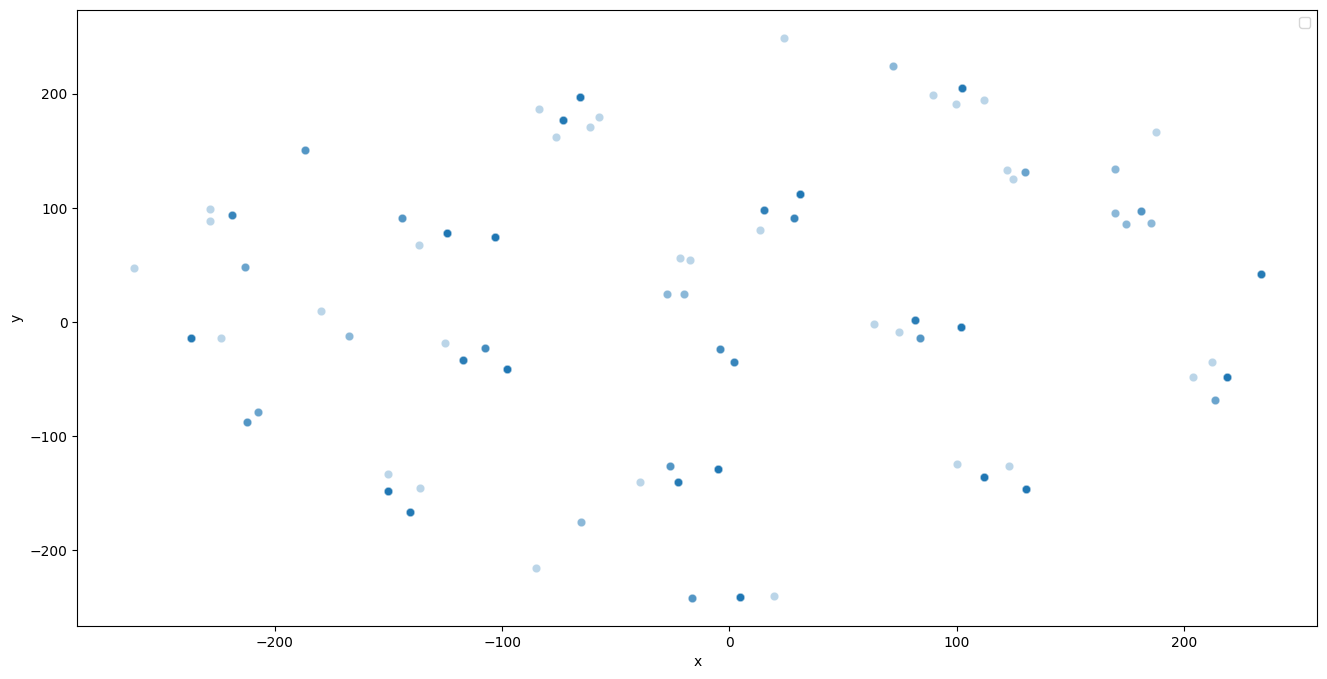

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
df_tsne = pd.DataFrame()
df_tsne['x'] = r_tsne[:,0]
df_tsne['y'] = r_tsne[:,1]
plt.figure(figsize=(16,8))
sns.scatterplot(
    x='x',
    y='y',
    # hue=predicao,
    # palette=sns.color_palette("hls", len(set(predicao))),
    data=df_tsne,
    legend="full",
    alpha=0.3
)
plt.legend(loc='upper right')
plt.show()